In [1]:
%load_ext autoreload
%autoreload 2
import ls_stat
import numpy as np
import scipy.io
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from scipy import stats

plt.rcParams['figure.dpi'] = 140
plt.rcParams['font.size']=8

In [10]:
%matplotlib widget


## The Oakridge Earthflow Observatory

In [7]:
project_root_path = Path(ls_stat.__file__).parents[1]
path = project_root_path/"data"/"raw"/"Ext_Data.mat"
mat = scipy.io.loadmat(path)
slip = np.array(mat["dsdisp_mx1048"])[:,0]
t = np.array(mat["mdate_mx1048"])[:,0]
slip_rate = np.diff(slip)

Text(0.5, 0, 'Time (days)')

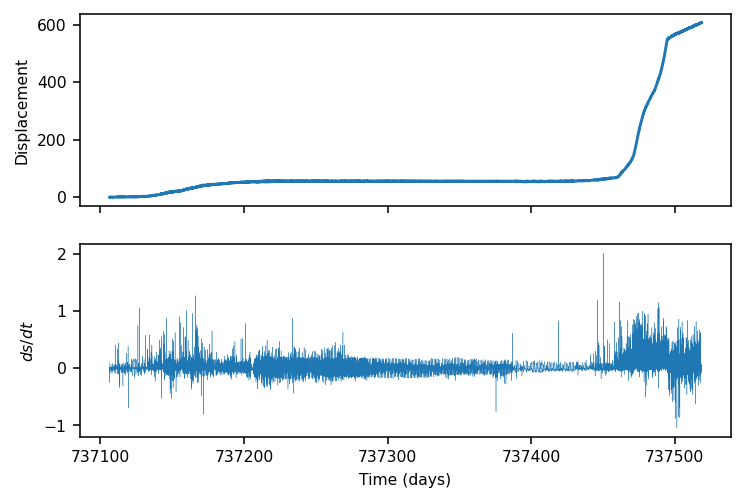

In [8]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t,slip)
ax[0].set_ylabel("Displacement")
ax[1].plot(t[1:],np.diff(slip),lw=0.2)
ax[1].set_ylabel(r"$ds/dt$")
ax[1].set_xlabel("Time (days)")

### How to define a slip event?

The raw data raises the question of how to define a slip event, a crude approach would be to consider a slip event to be any increment of slip with a magnitue of slip greater than some threshold. What is the correct threshold?

Text(0.5, 0, 'Slip')

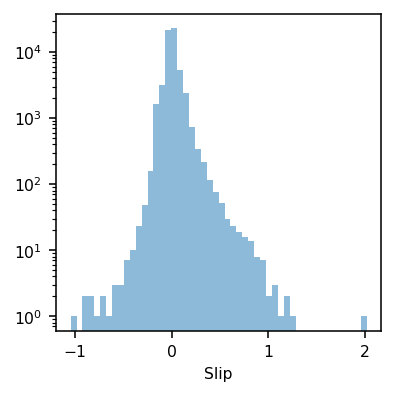

In [9]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(slip_rate,bins=50,log=True,alpha=0.5);
ax.set_xlabel('Slip')

A quick hack could be to consider that the instrumental noise might involve random fluctuations, i.e. positive or negative whereas 'signal' should exceed this:

/var/folders/1l/gktffm893cq4vlw9t22xy7jw0000gn/T/ipykernel_820/2993040900.py:9: RuntimeWarning: divide by zero encountered in true_divide
  R  =noise_and_signal[0]/noise_proxy[0]
/var/folders/1l/gktffm893cq4vlw9t22xy7jw0000gn/T/ipykernel_820/2993040900.py:9: RuntimeWarning: invalid value encountered in true_divide
  R  =noise_and_signal[0]/noise_proxy[0]


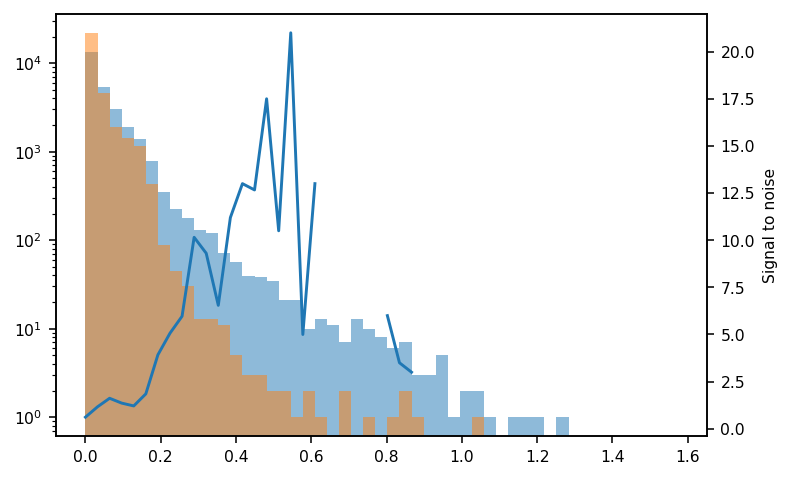

In [157]:
bin_limit = np.quantile(slip_rate, 0.99999)
bins = np.linspace(0,bin_limit,50)
signal2noise_threshold = 20
fig, ax = plt.subplots()
noise_and_signal         = ax.hist(slip_rate[slip_rate>0],bins=bins,log=True,alpha=0.5)
noise_proxy              = ax.hist(-slip_rate[slip_rate<0],bins=bins,log=True,alpha=0.5)

axb = ax.twinx()
R  =noise_and_signal[0]/noise_proxy[0]
axb.plot(bins[0:-1],R)
axb.set_ylabel('Signal to noise')

slip_rate_threshold = bins[np.argmax(R>signal2noise_threshold)]

## Problem:
Some of these events are consecutive...

I suggest that these represent one continuous event

Number of event detected: 128


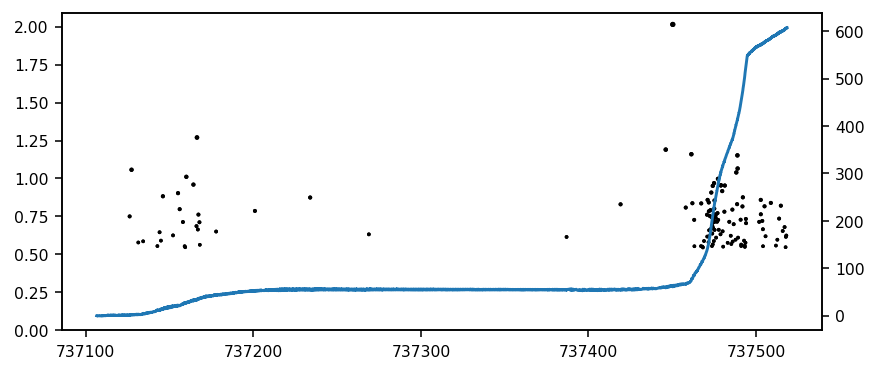

In [158]:
I = slip_rate>slip_rate_threshold

event_slip = []
event_arrival_times = []
event_duration = [] # VERY COARSE ESTIMATE
assert I[0] is not True, "This is annoying"

for i, does_slip in enumerate(I):
    if does_slip:
        # if I[i-1] and not(i==0):
        #     event_slip[-1]+=slip_rate[i]
        #     event_duration[-1]+=t[i+1]-t[i]
        # else:
        event_slip.append(slip_rate[i])
        event_arrival_times.append(t[i])
        event_duration.append(t[i+1]-t[i])

event_slip = np.array(event_slip)
event_arrival_times = np.array(event_arrival_times)
event_duration = np.array(event_duration)

print(f'Number of event detected: {np.sum(slip_rate>slip_rate_threshold)}')

fig,ax = plt.subplots(figsize=(7,3))
ax.scatter(
    event_arrival_times,
    event_slip,
    s=event_slip/np.mean(event_slip),
    c='k',
)

ax.scatter(event_arrival_times,
    event_slip,
    s=event_slip/np.mean(event_slip),
    c='k',
)
ax.set_ylim((0,None))
axb.set_ylim((0,None))
axb = ax.twinx()
axb.plot(t,slip)

We can get a sense of the slip rates involved

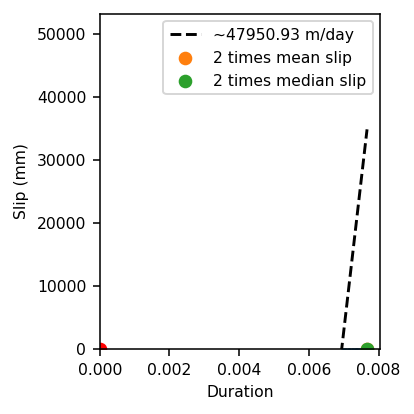

In [159]:
# assuming a fit through the data:
fig,ax = plt.subplots(figsize=(3,3))
jitter_factor = (1+0.1*np.random.random(len(event_duration)))
ax.scatter(event_duration*jitter_factor,event_slip,s=0.2,alpha=0.2)
x = np.array(ax.get_xlim())
x[0] = 0
p = np.polyfit(event_duration,event_slip,1)
ax.plot(x,p[1]+p[0]*x,'--k',label=f"~{p[0]/1000:0.2f} m/day")
ax.scatter(0,0,c='r')
ax.scatter(x[1],np.mean(event_slip)*2,label="2 times mean slip")
ax.scatter(x[1],np.median(event_slip)*2,label="2 times median slip")
ax.legend()
ax.set_ylim((0,None))
ax.set_xlim((0,None))
ax.set_ylabel("Slip (mm)")
ax.set_xlabel("Duration")
plt.tight_layout()

# assuming that evetnts slip 

In [160]:
assert min(event_slip) > slip_rate_threshold
if np.any(I[1:] & I[:-1]):
    assert np.sum(I)>len(event_slip)
else:
    assert len(event_arrival_times) == np.sum(I)

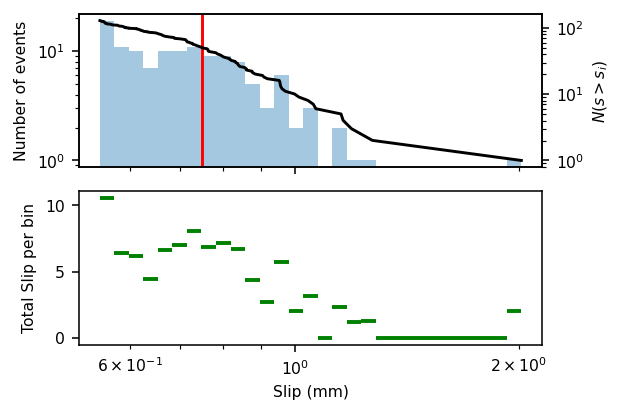

In [161]:
fig, AX = plt.subplots(2,1,sharex=True,figsize=(4.5,3))
ax,ax2 = AX
bins = np.logspace(np.log10(slip_rate_threshold),np.log10(max(event_slip)),30)
ax.hist(event_slip,bins=bins,log=True,alpha=0.4)
ax.set_xscale('log')
ax.set_ylabel('Number of events')

axb = ax.twinx()
axb.set_ylabel('$N(s>s_i)$')

s_sorted = np.sort(event_slip)
axb.plot(s_sorted,np.linspace(len(s_sorted),0,len(s_sorted))+1,'k')
axb.set_yscale('log')

ax.axvline(0.75,c="r",label="Characteristic events?") # ~ 10 cm of slip 

bin_sums, bin_edges, binnumber = stats.binned_statistic(s_sorted, s_sorted, statistic='sum', bins=bins)
ax2.hlines(bin_sums, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
           label='binned statistic of data')
ax2.set_ylabel('Total Slip per bin')

ax2.set_xlabel('Slip (mm)')
plt.tight_layout()

**Figure**: **Top** histogram and survival function for slip events. **Bottom** Slip per log-spaced bin. Note that unlike earthquakes, the slip *increases* as the mean slip per bin decreases. I interpret this to indicate that slip is carried by small magnitude events.

Following Kagan and Schoenberg 2001, we can fit a tapered pareto distribution to this dataset. Note that according the authors, even ~1000 events is not necessarily enough to get a good estimate of the upper bound of the data. Nonetheless, we proceed:

$$ F(x) = 1 - \left(\dfrac{a}{x}\right)^\beta \exp\left(\dfrac{a-x}{\theta}\right) $$

and

$$ f(x) = \left(\dfrac{\beta}{x}+\dfrac{1}{x}\right)\left(\dfrac{a}{x}\right)^\beta \exp\left(\dfrac{a-x}{\theta}\right) $$

here $a$ is the observational completeness threshold, $\beta$ is a shape paramters governing the power law decrease and $\theta$ is the upper cutoff parameter governing the location of the exponential taper to zero frequency.  

Here I estimate the shape and truncation parameters using a simple grid search on the log-likelihood:



/var/folders/1l/gktffm893cq4vlw9t22xy7jw0000gn/T/ipykernel_820/4255018633.py:23: RuntimeWarning: invalid value encountered in log10
  im = ax.contour(THETA,BETA,np.log10(grid),200,linewidths=0.5)


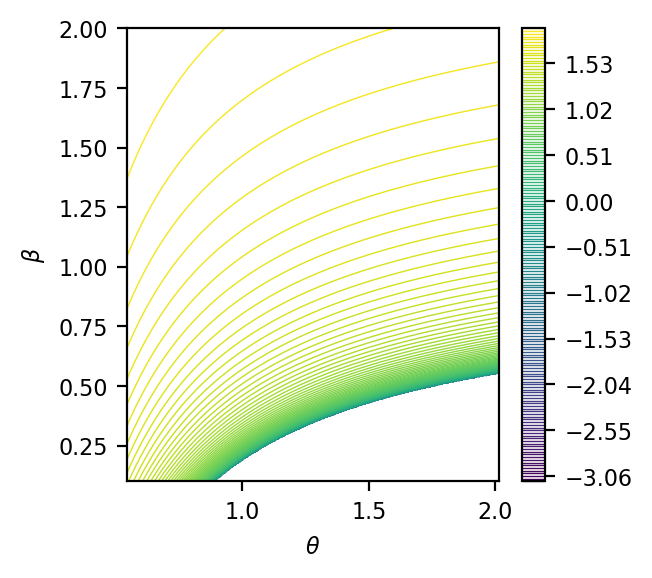

In [165]:
a = slip_rate_threshold
x = s_sorted[:-1]
n = len(x)

F =    lambda beta,theta,x: 1-(a/x)**beta * np.exp((a-x)/theta)
logL = lambda beta,theta:   (np.log( beta/x + 1/theta)).sum() + beta * n * np.log(a) - beta * (np.log(x)).sum() + a*n/theta - 1/theta * x.sum()

beta_range = [0.1,2]
theta_range= [a,np.max(event_slip)]

I,J = [800,600]

BETA = np.linspace(*beta_range,I)
THETA= np.linspace(*theta_range,J)

grid = np.zeros([I,J])

for i, ibeta in enumerate(BETA):
    for j, jtheta in enumerate(THETA):
        grid[i,j] = logL(ibeta,jtheta)

fig, ax = plt.subplots(figsize=(3,3),dpi=200)
im = ax.contour(THETA,BETA,np.log10(grid),200,linewidths=0.5)
ax.set_ylabel(r'$\beta$')
ax.set_xlabel(r'$\theta$')
plt.colorbar(im)

Figure: Grid search over shape ($\beta$) and exponential decay limit ($\theta$). Note that this represents the twice-logged likelihood (i.e. the hessian around the maximum value is very small and uncertainty on the paramers is correspondingly large). Also note that $\beta \approx 1$ should not be confused with the b-value. I'll further add that converting from slip to magnitude may be fraught, for instance, the free surface is very likely to influence magntidue/slip scaling relationships.

slope: 2.0
exponential taper: 0.5455223651879404


/var/folders/1l/gktffm893cq4vlw9t22xy7jw0000gn/T/ipykernel_820/289701954.py:25: RuntimeWarning: invalid value encountered in log10
  im = ax2.contour(THETA,BETA,np.log10(grid),300,linewidths=0.5)


Text(0.5, 0, '$\\theta$')

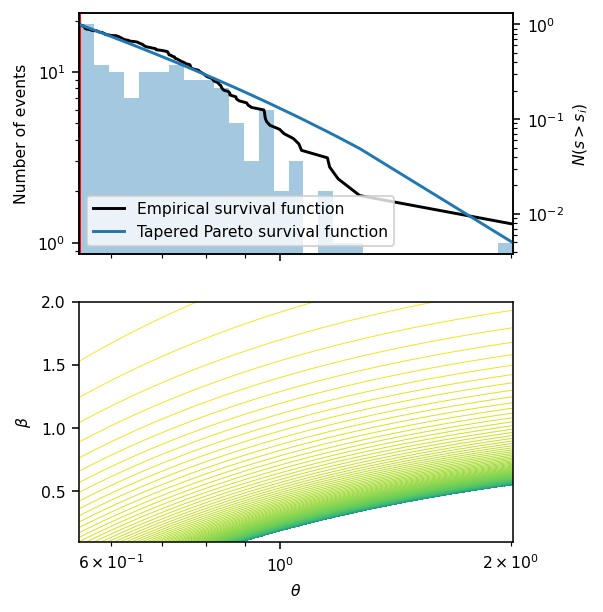

In [166]:
# chosen paramters:
T_grid,B_grid = np.meshgrid(THETA,BETA)
maxindex = np.unravel_index(np.argmax(grid),grid.shape)
beta_hat = B_grid[maxindex]
theta_hat= T_grid[maxindex]

print(f"slope: {beta_hat}\nexponential taper: {theta_hat}")

fig, AX = plt.subplots(2,1,figsize=(4,5),sharex=True)
ax,ax2 = AX
bins = np.logspace(np.log10(slip_rate_threshold),np.log10(max(event_slip)),30)
ax.hist(event_slip,bins=bins,log=True,alpha=0.4)
ax.set_xscale('log')
ax.set_ylabel('Number of events')
axb = ax.twinx()
axb.set_ylabel('$N(s>s_i)$')
s_sorted = np.sort(event_slip)
emprical_survival = (np.linspace(1,0,len(s_sorted)+1))[:-1]
axb.plot(s_sorted,emprical_survival,'k',label='Empirical survival function')
axb.plot(s_sorted, 1-F(beta_hat,theta_hat,s_sorted), label="Tapered Pareto survival function")
axb.legend()
axb.set_yscale('log')

ax.axvline(theta_hat,c="r",label="Characteristic events?") # ~ 10 cm of slip 
im = ax2.contour(THETA,BETA,np.log10(grid),300,linewidths=0.5)
ax2.set_ylabel(r'$\beta$')
ax2.set_xlabel(r'$\theta$')


## Clustering

I fit the following gamma distribution to the inter-event time population:
$$ f(\tau) = \dfrac{ \beta^\alpha \tau^\alpha e^{-\beta \tau}}{\Gamma(\alpha)} $$

Following Molchan (2005), $\beta$ ca be interpreted as the fraction of 'mainshocks' under the assumption of a poissonian background. Note that the above equation essentially comprises a term for aftershock decay and a an exponential term for the poissonian baground.

Text(0.5, 0, 'Inter-event time (days)')

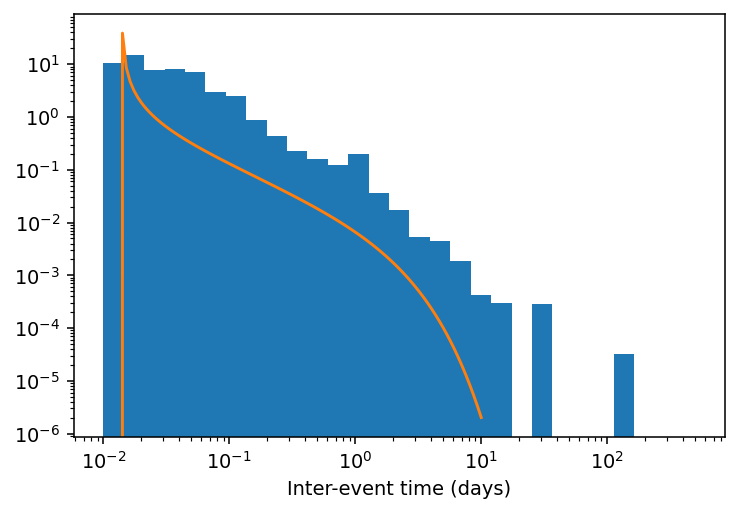

In [ ]:
from scipy import stats
tau = np.diff(event_arrival_times)
fit_alpha, fit_loc, fit_beta=stats.gamma.fit(tau)
x=np.logspace(np.log10(0.01),np.log10(500),30)
fig,ax = plt.subplots()
ax.hist(tau,bins=x,density=True,histtype='stepfilled')

x=np.logspace(np.log10(0.01),np.log10(10),100)
ax.plot(x,stats.gamma.pdf(x,fit_alpha,loc=fit_loc,scale=fit_beta))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Inter-event time (days)')

In [ ]:
# per Liu and others:
tau_norm = tau/np.mean(tau)
print(1/np.std(tau_norm))
print(1/fit_beta)
# note that these are different possibly due to censoring of the data?

0.12966394961633865
0.6446364869436956
